# Borrow My Style: E-commerce Inventory Trends

Notebook by: Emmanuel Contreras-Campana, Ph.D.

## Load Libraries

In [118]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.pyplot import *
from matplotlib import colors

from collections import OrderedDict

from sklearn.externals import joblib

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# #from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler,
                                   LabelEncoder, OneHotEncoder)

from sklearn.metrics import (roc_auc_score, log_loss, f1_score, 
                             average_precision_score, precision_score, 
                             brier_score_loss, recall_score, accuracy_score,
                             classification_report)

from imblearn.pipeline import make_pipeline

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# random seed
seed = 42

% matplotlib inline

## Load user utilities

In [2]:
%run -i utilities.py

## Load Data

In [3]:
# load items
items = pd.read_csv(filepath_or_buffer='items.csv', sep=',',
                    header='infer', index_col=0,
                    dtype={'id': 'int', 'cost': 'float', 'rent_per_week': 'float',
                           'size': 'str', 'created_at': 'str', 'removed_at': 'str',
                           'rental_count': 'float'},
                    parse_dates=['created_at', 'removed_at']
                   )

# load orders
orders = pd.read_csv(filepath_or_buffer='orders.csv', sep=',',
                     header='infer', index_col=0, 
                     dtype={'item_id': 'int', 'rental_id': 'int', 'size': 'str',
                            'item_price': 'float', 'rent_per_week': 'float',
                            'created_at': 'str', 'removed_at': 'str'},
                     parse_dates=['created_at', 'removed_at']
                    )

## Feature Engineering

In [4]:
# map categorical dress size to numeric value
dress_sizes = {'XS': '4', 'S': '6', 'M': '8', 'One-Size': '4', '00': '0'}

# map item type with size None to most frequent numeric value
item_type_sizes = {'bottoms': '4', 'dresses': '4', 'shoes': '8', 
                   'skirts': '4', 'tops': '4', 'bags': 'One-Size',
                   'outerwear': '4'}


categorical_sizes = ['XS', 'S', 'M', 'One-Size', '00']

apparel  = ['tops', 'skirts', 'pants', 'outerwear', 'rompers', 'shirts', 'dresses', 'bottoms']

In [5]:
# calculate lifetimes of each individual item
# lifetime = number of weeks from date of creation to date of removal

f = lambda df: int((df['removed_at'].to_pydatetime()-df['created_at']).days)/7.0
                   
items['lifetime'] = items.apply(f, axis=1)

# set None lifetime values to 1
items['lifetime'] = items['lifetime'].apply(lambda lt: lt if lt != 0 else 1)

In [6]:
# calculate rental frequency for each individual item

items['rental_frequency'] = items.apply(lambda df: df['rental_count']/df['lifetime'], axis=1)

In [7]:
# Fill all size None with most the frequent size of their respective item type

items['size'] = items['size'].astype(object).where(pd.notnull(items['size']), None)

f = lambda df: item_type_sizes[df['item_type']] if df['size'] is None else df['size']

items['size'] = items.apply(f, axis=1)

In [8]:
# transform categorical items sizes into numerical values

f = lambda s: dress_sizes[s['size']] if s['item_type'] in apparel and s['size'] in categorical_sizes else s['size']

items['size'] = items.apply(f, axis=1)

# Data Science

We use only a subset of all item types, namely those of apparel, which inlcude'tops', 'skirts', 'pants', 'outerwear', 'rompers', 'shirts', 'dresses', and 'bottoms'

In [9]:
data = items[items['item_type'].isin(apparel)].copy()

# transform size string to float
data['size'] = data['size'].apply(float)

In [10]:
rental_freq = data.query('rental_frequency!=0')['rental_frequency'].sort_values(ascending=True)

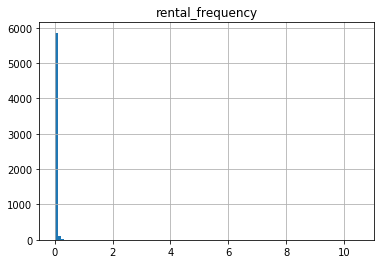

In [11]:
data.hist('rental_frequency', bins=100);

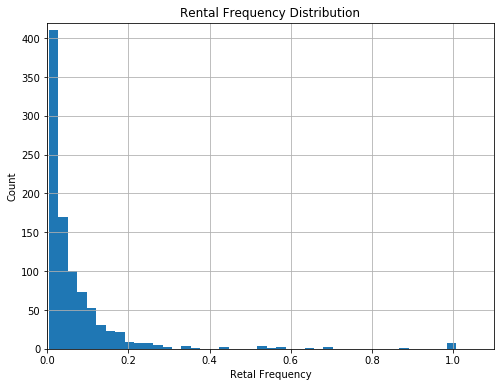

In [12]:
data.query('rental_frequency!=0')['rental_frequency'].hist(bins=450, figsize=(8, 6))

plt.ylim(0, 420)
plt.xlim(0, 1.1)

plt.title('Rental Frequency Distribution')
plt.xlabel('Retal Frequency')
plt.ylabel('Count');

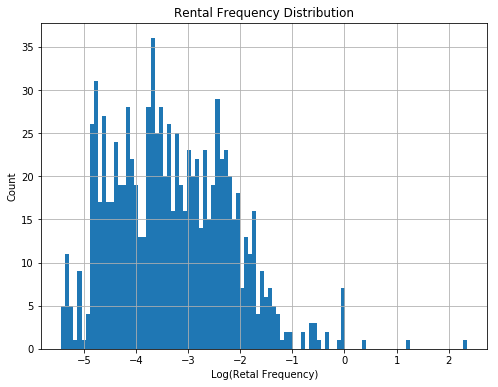

In [13]:
ax = np.log(data.query('rental_frequency!=0').rental_frequency).hist(bins=100, figsize=(8, 6))

plt.title('Rental Frequency Distribution')
plt.xlabel('Log(Retal Frequency)')
plt.ylabel('Count');

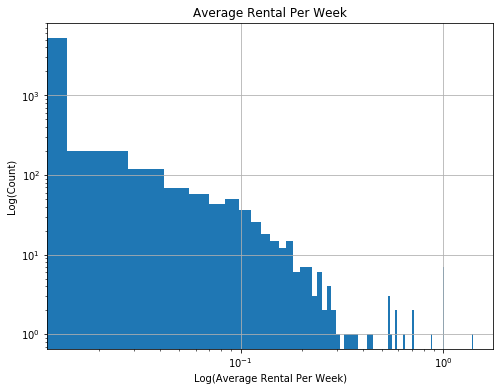

In [258]:
fig, ax = plt.subplots(figsize=(8, 6))

data.query('rental_frequency < 2').hist(column='rental_frequency', ax=ax, bins=100)
ax.set_yscale('log')
ax.set_xscale('log')

plt.title('Average Rental Per Week')
plt.xlabel('Log(Average Rental Per Week)')
plt.ylabel('Log(Count)');

In [15]:
# categorize rental_frequency

rental_frequency_treshold = 0.03333  #0.03333 (50th percentile) #0.0973 (80th percentile)

f = lambda df: 0 if df['rental_frequency']==0 else (1 if df['rental_frequency']<rental_frequency_treshold else 2)

data['rental_category'] = data.apply(f, axis=1)

In [16]:
data.groupby(['rental_category']).count()['id']

rental_category
0    5091
1     468
2     471
Name: id, dtype: int64

# One-Hot Encoding Categorical Features

In [18]:
X_raw = data[['item_type', 'brand', 'size', 'rent_per_week']]
y = data['rental_category']

In [19]:
X_ohe = pd.get_dummies(X_raw[['brand', 'item_type']], prefix=['brand', 'item_type'])

In [20]:
X = X_raw[['size', 'rent_per_week']].join(X_ohe)

# Standardize features

In [21]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:
# These datasets are only used for overfitting plots
# cross-validation of hyper-parameter and model evaluation
# are performed with full dataset

X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.30, random_state=42)

In [23]:
# Produce standardized features
sns = scaler.fit(X_train[['size', 'rent_per_week']]) 

X_train[['rent_per_week', 'size']] = pd.DataFrame(scaler.transform(X_train[['rent_per_week', 'size']]),
                                                     columns=['rent_per_week', 'size'], index=X_train.index)

X_test[['rent_per_week', 'size']] = pd.DataFrame(scaler.transform(X_test[['rent_per_week', 'size']]),
                                                    columns=['rent_per_week', 'size'], index=X_test.index)

# Modeling

In [24]:
## Stratified K-Fold cross-validation
k_fold = 3

outer_kfold_cv = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=seed)
inner_kfold_cv = StratifiedKFold(n_splits=k_fold-1, shuffle=True, random_state=seed)

## Random Over Sampling of minority class
ros = RandomOverSampler(ratio='all', random_state=1)

<class 'sklearn.dummy.DummyClassifier'>
Accuracy score on train data: 0.7263681592039801
Accuracy score on test data: 0.7114427860696517

Precision score on train data: [0.84445067 0.07878788 0.08359133]
Precision score on test data: [0.84196547 0.07792208 0.04697987]

Recall score on train data: [0.84374125 0.07831325 0.08490566]
Recall score on test data: [0.83421053 0.08823529 0.04575163]

Log loss on train data: 9.45090896378153
Log loss on test data: 9.966413089078703
<class 'sklearn.dummy.DummyClassifier'>
DummyClassifier
Using model file stored in oversampling


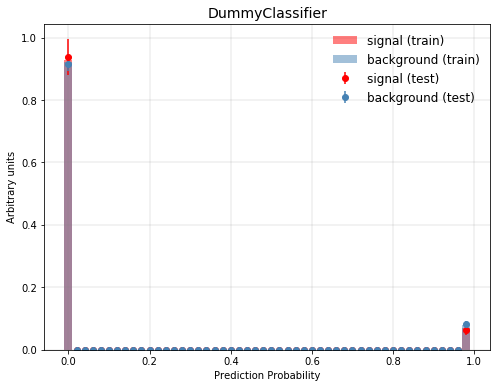

None

In [59]:
## Fitting a dummy model (baseline model)

# Dummy classifier model
dc = DummyClassifier(strategy='stratified', random_state=1) # 'most_frequent', 'stratified'

# Fit model
dc.fit(X_train, y_train)

# Persist model
joblib.dump(dc, 'oversampling/DummyClassifier.pkl')

# Load model
dc = joblib.load('oversampling/DummyClassifier.pkl')

# Evaluate model performance with accuracy
summary_report(dc, y_test, y_train, X_test, X_train)

# Plot overfitting
plot_overfitting(dc, X_train, X_test, y_train, y_test,
                 bins=50, directory='oversampling')

fold- 1 model fitting ...
{'memory': None, 'steps': [('randomoversampler', RandomOverSampler(random_state=1, ratio='all')), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gradientboostingclassifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))], 'randomoversampler': RandomOverSampler(random_state=1, ratio='all'), 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'gradientboostingclassifier': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', ma

<class 'sklearn.model_selection._search.GridSearchCV'>
Accuracy score on train data: 0.8367685382610756
Accuracy score on test data: 0.8325041459369817

Precision score on train data: [0.84667147 0.11627907 0.23529412]
Precision score on test data: [0.84213483 0.15789474 0.4       ]

Recall score on train data: [0.98655839 0.01506024 0.01257862]
Recall score on test data: [0.98618421 0.02205882 0.02614379]

Log loss on train data: 0.5535293306453558
Log loss on test data: 0.5644193897762319
<class 'sklearn.model_selection._search.GridSearchCV'>
ecc
GradientBoostingClassifier
Using model file stored in oversampling


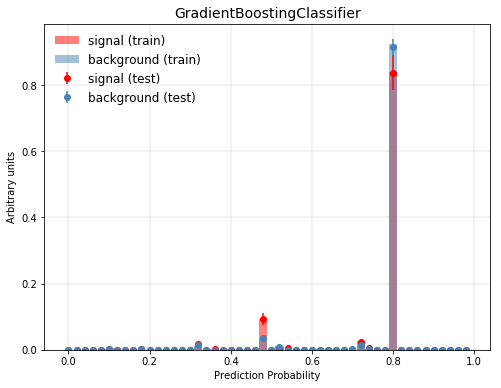

None

<class 'sklearn.model_selection._search.GridSearchCV'>
ecc
GradientBoostingClassifier
Using model file stored in oversampling


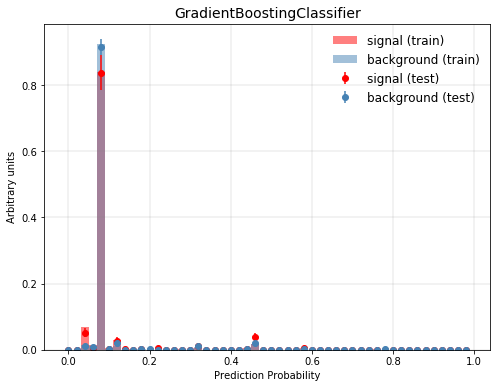

None

<class 'sklearn.model_selection._search.GridSearchCV'>
ecc
GradientBoostingClassifier
Using model file stored in oversampling


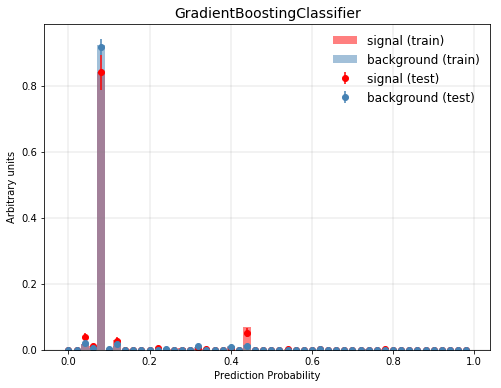

None

In [63]:
## Fitting a Gradient Boosting classifier

# Hyper-parameter space
name = 'GradientBoostingClassifier'.lower()

param_grid = {name+'__'+'learning_rate': [0.1, 0.2],
              name+'__'+'n_estimators': [5, 10, 15],
              name+'__'+'max_depth': [None, 2, 5]}

# Extra tree classifier model
gbd = GradientBoostingClassifier()

pipe = make_pipeline(ros, scaler, gbd)

# Hyper-parameter optimization and model evaluation using nested cross-validation
gbd = grid_search(pipe, X, y,
                  outer_kfold_cv, inner_kfold_cv,
                  param_grid, scoring='neg_log_loss')

# Persist model
joblib.dump(gbd, 'oversampling/GradientBoostingClassifier.pkl')

# Load model
gbd = joblib.load('oversampling/GradientBoostingClassifier.pkl')

# Evaluate model performance with accuracy
summary_report(gbd, y_test, y_train, X_test, X_train)

# Plot overffiting
plot_overfitting(gbd, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=0, directory='oversampling')

plot_overfitting(gbd, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=1, directory='oversampling')

plot_overfitting(gbd, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=2, directory='oversampling')

fold- 1 model fitting ...
{'memory': None, 'steps': [('randomoversampler', RandomOverSampler(random_state=1, ratio='all')), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))], 'randomoversampler': RandomOverSampler(random_state=1, ratio='all'), 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'randomforestclassifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_

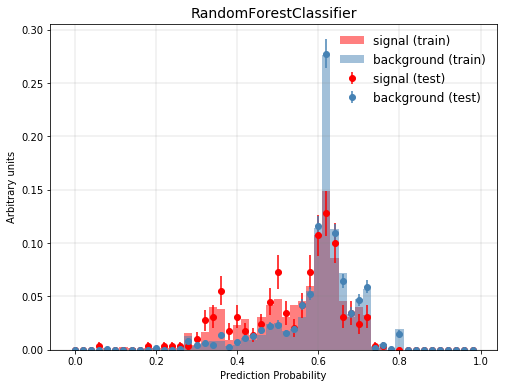

None

<class 'sklearn.model_selection._search.GridSearchCV'>
ecc
RandomForestClassifier
Using model file stored in oversampling


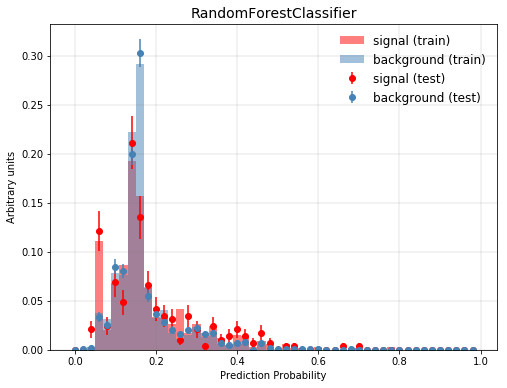

None

<class 'sklearn.model_selection._search.GridSearchCV'>
ecc
RandomForestClassifier
Using model file stored in oversampling


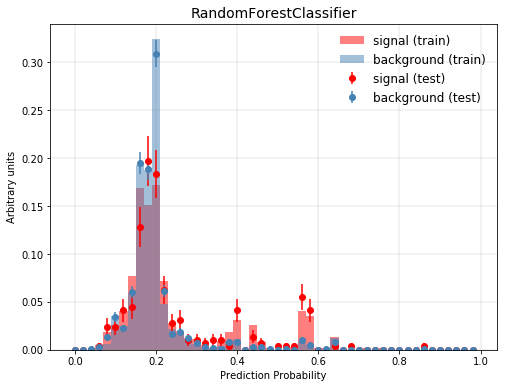

None

In [64]:
## Fitting Random forest classifier

# Hyper-parameter space
name = 'RandomForestClassifier'.lower()

param_grid = {name+'__'+'n_estimators': [5, 10, 15, 20, 25, 50],
              name+'__'+'max_depth': [None, 2, 5],
              name+'__'+'min_samples_leaf': [1, 2, 3]}

# Hyper-parameter optimization and model evaluation using nested cross-validation
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)

pipe = make_pipeline(ros, scaler, rfc)

# Random forest classifier model
rfc = grid_search(pipe, X, y, 
                  outer_kfold_cv, inner_kfold_cv,
                  param_grid, scoring='neg_log_loss')

# Persist model
joblib.dump(rfc, 'oversampling/RandomForestClassifier.pkl');

# Load model
rfc  = joblib.load('oversampling/RandomForestClassifier.pkl')

# Evaluate model performance with accuracy
summary_report(rfc, y_test, y_train, X_test, X_train)

# Plot overffiting
plot_overfitting(rfc, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=0, directory='oversampling')

plot_overfitting(rfc, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=1, directory='oversampling')

plot_overfitting(rfc, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=2, directory='oversampling')

fold- 1 model fitting ...
{'memory': None, 'steps': [('randomoversampler', RandomOverSampler(random_state=1, ratio='all')), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='sag',
          tol=0.001, verbose=0, warm_start=False))], 'randomoversampler': RandomOverSampler(random_state=1, ratio='all'), 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'logisticregression': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='sag',
          tol=0.001, verbose=0, warm_start=False), 'randomoversampler__random_state': 1, 'randomoversampler__ratio': 'a

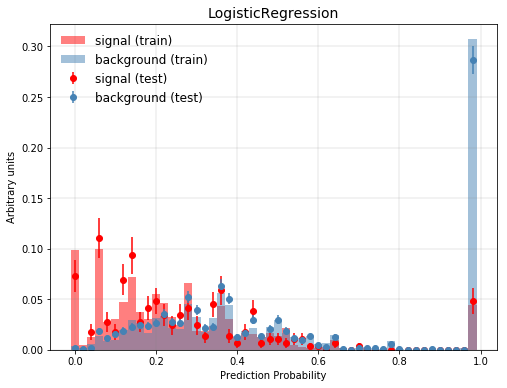

None

<class 'sklearn.model_selection._search.GridSearchCV'>
ecc
LogisticRegression
Using model file stored in oversampling


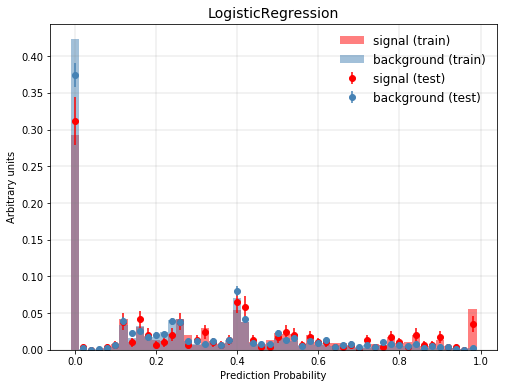

None

<class 'sklearn.model_selection._search.GridSearchCV'>
ecc
LogisticRegression
Using model file stored in oversampling


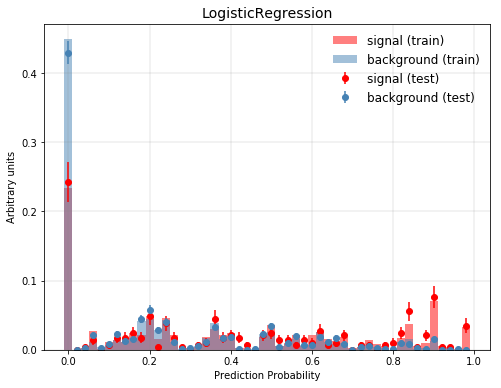

None

In [65]:
## Fitting a logistic regression model with ridge regression

# Hyper-parameter space
name = 'LogisticRegression'.lower()

param_grid = {name+'__C': [0.1, 1, 10]}

# Losgistic regression model
log = LogisticRegression(penalty='l2', C=0.1, 
                         solver='sag', #'liblinear', #'lbfgs', #'sag',
                         max_iter=1000, n_jobs=-1,
                         tol= 1e-3,
                         class_weight=None,
                         multi_class='multinomial')

pipe = make_pipeline(ros, scaler, log)

# Hyper-parameter optimization and model evaluation using nested cross-validation
log = grid_search(pipe, X, y,
                  outer_kfold_cv, inner_kfold_cv,
                  param_grid, scoring='neg_log_loss')

# Persist model
joblib.dump(log, 'oversampling/LogisticRegression.pkl')

# Load model
log = joblib.load('oversampling/LogisticRegression.pkl')

# Evaluate model performance
summary_report(log, y_test, y_train, X_test, X_train)

# Plot overffiting
plot_overfitting(log, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=0, directory='oversampling')

plot_overfitting(log, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=1, directory='oversampling')

plot_overfitting(log, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=2, directory='oversampling')

fold- 1 model fitting ...
{'memory': None, 'steps': [('randomoversampler', RandomOverSampler(random_state=1, ratio='all')), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=30, p=2,
           weights='uniform'))], 'randomoversampler': RandomOverSampler(random_state=1, ratio='all'), 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'kneighborsclassifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=30, p=2,
           weights='uniform'), 'randomoversampler__random_state': 1, 'randomoversampler__ratio': 'all', 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__leaf_size': 30, 'kneighborscla

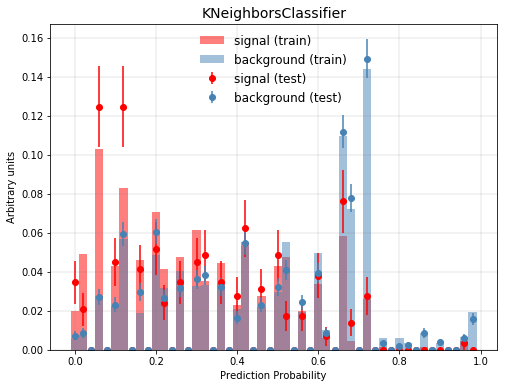

None

<class 'sklearn.model_selection._search.GridSearchCV'>
ecc
KNeighborsClassifier
Using model file stored in oversampling


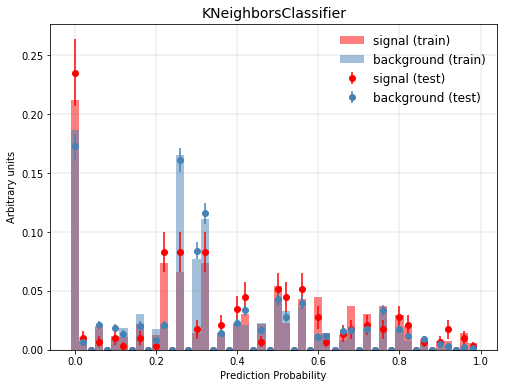

None

<class 'sklearn.model_selection._search.GridSearchCV'>
ecc
KNeighborsClassifier
Using model file stored in oversampling


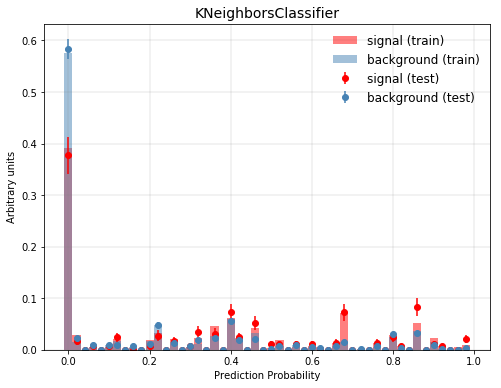

None

In [61]:
## Fitting a K-Neighbors classifier

# Hyper-parameter space
name = 'KNeighborsClassifier'.lower()

param_grid = {name+'__n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20, 30],
              name+'__weights': ['uniform', 'distance']}

# Hyper-parameter optimization and model evaluation using nested cross-validation
knn = KNeighborsClassifier(n_jobs=-1)

pipe = make_pipeline(ros, scaler, knn)

# K-Neighbors classifier model
knn = grid_search(pipe, X, y, 
                  outer_kfold_cv, inner_kfold_cv,
                  param_grid, scoring='neg_log_loss')

# Persist model
joblib.dump(knn, 'oversampling/KNeighborsClassifier.pkl');

# Load model
knn  = joblib.load('oversampling/KNeighborsClassifier.pkl')

# Evaluate model performance with accuracy
summary_report(knn, y_test, y_train, X_test, X_train)

# Plot overffiting
plot_overfitting(knn, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=0, directory='oversampling')

plot_overfitting(knn, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=1, directory='oversampling')

plot_overfitting(knn, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=2, directory='oversampling')

fold- 1 model fitting ...
{'memory': None, 'steps': [('randomoversampler', RandomOverSampler(random_state=1, ratio='all')), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))], 'randomoversampler': RandomOverSampler(random_state=1, ratio='all'), 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'svc': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'randomoversampler__random_state': 1, 'randomoversampler__ratio': 'all', 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'svc__C': 10, 's

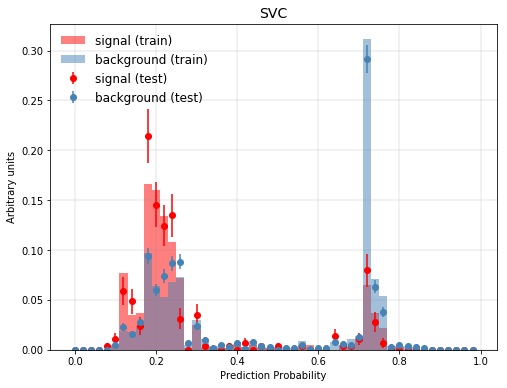

None

<class 'sklearn.model_selection._search.GridSearchCV'>
ecc
SVC
Using model file stored in oversampling


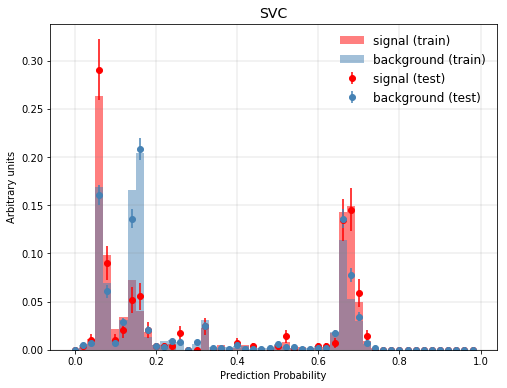

None

<class 'sklearn.model_selection._search.GridSearchCV'>
ecc
SVC
Using model file stored in oversampling


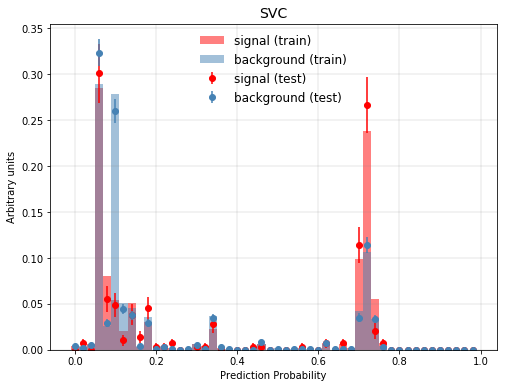

None

In [66]:
## Fitting a Support vector classifier

# Hyper-parameter space
name = 'SVC'.lower()

param_grid = {name+'__C': [0.5, 1, 5, 10]}

# Support vector machine model
svm = SVC(probability=True)

pipe = make_pipeline(ros, scaler, svm)

# Hyper-parameter optimization and model evaluation using nested cross-validation
svm = grid_search(pipe, X, y,
                  outer_kfold_cv, inner_kfold_cv,
                  param_grid, scoring='neg_log_loss')

# Persist model
joblib.dump(svm, 'oversampling/SVC.pkl')

# Load model
svm = joblib.load('oversampling/SVC.pkl')

# Evaluate model performance with accuracy
summary_report(svm, y_test, y_train, X_test, X_train)

# Plot overffiting
plot_overfitting(svm, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=0, directory='oversampling')

plot_overfitting(svm, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=1, directory='oversampling')

plot_overfitting(svm, X_train, X_test, y_train, y_test,
                 bins=50, pos_class=2, directory='oversampling')

# Precision vs Recall

,Precision,Recall
Dummy Classifier,84.196547,83.421053
Gradient Boosting,87.303023,78.884306
Random Forest,88.455019,72.500491
Logistic Regression,89.019844,54.881163
K-Neighbors,89.732221,42.427814
Support Vector Machine,89.167722,45.983107


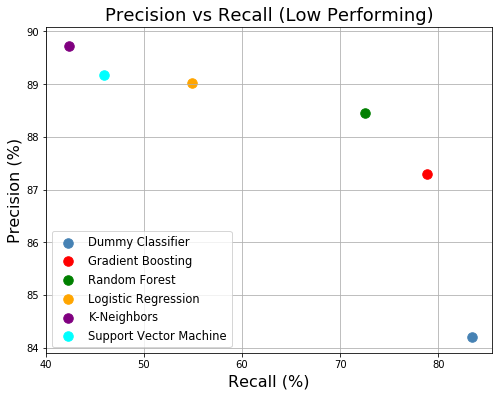

In [116]:
ml = OrderedDict()

ml['Dummy Classifier']       = [0.84196547*100, 0.83421053*100]
ml['Gradient Boosting']      = [0.87303023*100, 0.78884306*100]
ml['Random Forest']          = [0.88455019*100, 0.72500491*100]
ml['Logistic Regression']    = [0.89019844*100, 0.54881163*100]
ml['K-Neighbors']            = [0.89732221*100, 0.42427814*100]
ml['Support Vector Machine'] = [0.89167722*100, 0.45983107*100]


precision_recall = pd.DataFrame(data=list(ml.values()), 
                                index=ml.keys(),
                                columns=['Precision', 'Recall'])

fig, ax = plt.subplots()

colorlist = ['steelblue', 'red', 'green', 'orange', 'purple', 'cyan']

for i, l in enumerate(ml):
    precision_recall.iloc[[i]].plot(x='Recall', y='Precision', kind='scatter',
                                    figsize=(8, 6), ax=ax, s=90, label=l,
                                    color=colorlist[i], grid=True
                                   )


plt.title('Precision vs Recall (Low Performing)', fontsize=18)

plt.xlabel('Recall (%)', fontsize=16)
plt.ylabel('Precision (%)', fontsize=16)

plt.legend(prop={'size': 11.5})

display(precision_recall)

,Precision,Recall
Dummy Classifier,7.792208,8.823529
Gradient Boosting,12.318290,23.290598
Random Forest,14.509166,36.324786
Logistic Regression,12.350660,40.811966
K-Neighbors,10.427687,46.367521
Support Vector Machine,11.433255,42.948718


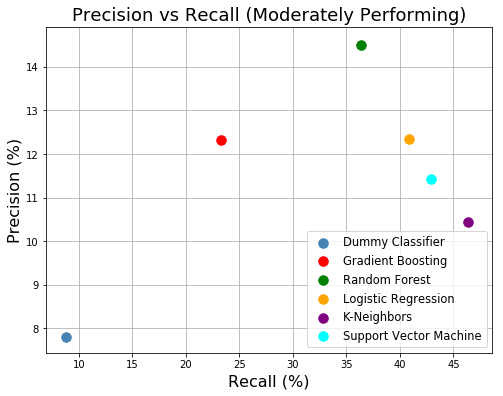

In [117]:
ml = OrderedDict()

ml['Dummy Classifier']       = [0.07792208*100, 0.08823529*100]
ml['Gradient Boosting']      = [0.1231829*100,  0.23290598*100]
ml['Random Forest']          = [0.14509166*100, 0.36324786*100]
ml['Logistic Regression']    = [0.1235066*100,  0.40811966*100]
ml['K-Neighbors']            = [0.10427687*100, 0.46367521*100]
ml['Support Vector Machine'] = [0.11433255*100, 0.42948718*100]


precision_recall = pd.DataFrame(data=list(ml.values()), 
                                index=ml.keys(),
                                columns=['Precision', 'Recall'])

fig, ax = plt.subplots()

colorlist = ['steelblue', 'red', 'green', 'orange', 'purple', 'cyan']

for i, l in enumerate(ml):
    precision_recall.iloc[[i]].plot(x='Recall', y='Precision', kind='scatter',
                                    figsize=(8, 6), ax=ax, s=90, label=l,
                                    color=colorlist[i], grid=True
                                   )


plt.title('Precision vs Recall (Moderately Performing)', fontsize=18)

plt.xlabel('Recall (%)', fontsize=16)
plt.ylabel('Precision (%)', fontsize=16)

plt.legend(prop={'size': 11.5}, loc=4)

display(precision_recall)

,Precision,Recall
Dummy Classifier,4.697987,4.575163
Gradient Boosting,22.743540,26.114650
Random Forest,23.099078,33.333333
Logistic Regression,17.903869,51.167728
K-Neighbors,15.855865,51.804671
Support Vector Machine,15.914071,54.564756


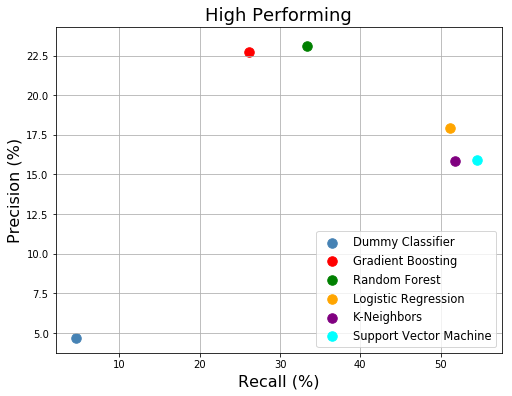

In [115]:
ml = OrderedDict()

ml['Dummy Classifier']       = [0.04697987*100, 0.04575163*100]
ml['Gradient Boosting']      = [0.2274354*100,  0.2611465*100]
ml['Random Forest']          = [0.23099078*100, 0.33333333*100]
ml['Logistic Regression']    = [0.17903869*100, 0.51167728*100]
ml['K-Neighbors']            = [0.15855865*100, 0.51804671*100]
ml['Support Vector Machine'] = [0.15914071*100, 0.54564756*100]


precision_recall = pd.DataFrame(data=list(ml.values()), 
                                index=ml.keys(),
                                columns=['Precision', 'Recall'])

fig, ax = plt.subplots()

colorlist = ['steelblue', 'red', 'green', 'orange', 'purple', 'cyan']

for i, l in enumerate(ml):
    precision_recall.iloc[[i]].plot(x='Recall', y='Precision', kind='scatter',
                                    figsize=(8, 6), ax=ax, s=90, label=l,
                                    color=colorlist[i], grid=True
                                   )


plt.title('High Performing', fontsize=18)

plt.xlabel('Recall (%)', fontsize=16)
plt.ylabel('Precision (%)', fontsize=16)


plt.legend(prop={'size': 11.5}, loc=4)

display(precision_recall)

# Log Loss

,log loss
Dummy Classifier,9.450909
Gradient Boosting,0.720873
Random Forest,0.838018
Logistic Regression,1.062011
KNeighbors,2.303290
Support Vector Machine,1.007302


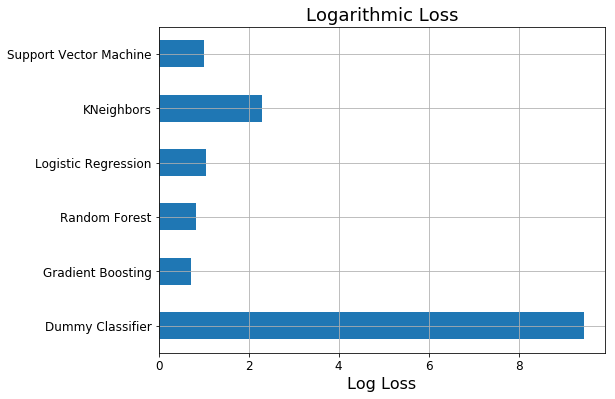

In [147]:
ml = OrderedDict()

ml['Dummy Classifier']       = 9.45090896378153
ml['Gradient Boosting']      = 0.7208726039328565
ml['Random Forest']          = 0.8380180430141219
ml['Logistic Regression']    = 1.062011157653542
ml['KNeighbors']             = 2.3032902858403044
ml['Support Vector Machine'] = 1.007301550578533


logloss = pd.DataFrame(data=list(ml.values()), index=ml.keys(), 
                       columns=['log loss'])

ax = logloss.plot(kind='barh', figsize=(8, 6), grid=True)

plt.title('Logarithmic Loss', fontsize=18)

plt.xlabel('Log Loss', fontsize=16)

ax.set_xticklabels(list(range(0, 12, 2)), rotation=0, fontsize=12)
ax.set_yticklabels(ml.keys(), rotation=0, fontsize=12)

ax.legend_.remove()

#plt.gca().invert_yaxis()

display(logloss)

# Feature Importance

In [162]:
log_coeff = pd.DataFrame(data=log.best_estimator_._final_estimator.coef_, index=[0, 1, 2], columns=X.columns)

,1
chanel,0.262503
clover canyon,0.239667
item price,0.221044
igigi,0.216960
fausto puglisi,0.211426


,1
size,-0.053127
item price,0.221044


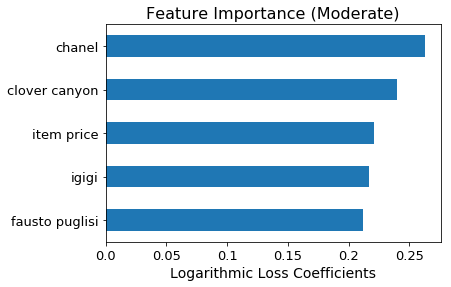

In [253]:
pos_class = 1
top_n = 5

m_class_log = log_coeff.iloc[[pos_class]].sort_values(by=[pos_class], axis=1, ascending=False).transpose()

m_class_log = m_class_log.rename({'brand_chanel': 'chanel',
                                  'brand_clover canyon': 'clover canyon',
                                  'rent_per_week': 'item price',
                                  'brand_igigi': 'igigi', 
                                  'brand_fausto puglisi': 'fausto puglisi',
                                  'rent_per_week': 'item price'})

m_class = m_class_log.iloc[range(0, top_n), :]

ax = m_class.plot(kind='barh')

plt.title('Feature Importance (Moderate)', fontsize=16)

plt.xlabel('Logarithmic Loss Coefficients', fontsize=14)

plt.gca().invert_yaxis()

rng = [float(x)/100 for x in range(0, 30, 5)]

ax.set_xticklabels(rng, rotation=0, fontsize=13)
ax.set_yticklabels(m_class.index, rotation=0, fontsize=13)

ax.legend_.remove()

display(m_class)

display(m_class_log.loc[['size', 'item price'], :])

,2
for love & lemons,0.518142
self-portrait,0.461480
brand_katya lee,0.245792
stone cold fox,0.212336
asilio,0.208288


,2
size,-0.100147
item price,0.159153


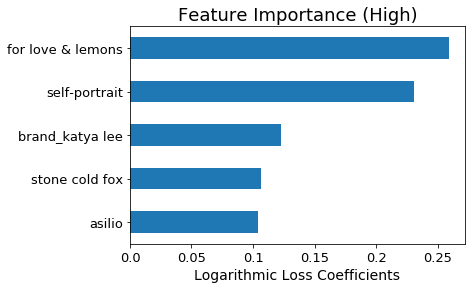

In [252]:
pos_class = 2
top_n = 5

m_class_log = log_coeff.iloc[[pos_class]].sort_values(by=[pos_class], axis=1, ascending=False).transpose()

m_class_log = m_class_log.rename({'brand_for love & lemons': 'for love & lemons',
                                  'brand_self-portrait': 'self-portrait',
                                  'brand_katya leek': 'katya lee',
                                  'brand_stone cold fox': 'stone cold fox', 
                                  'brand_asilio': 'asilio',
                                  'rent_per_week': 'item price'})

m_class = m_class_log.iloc[range(0, top_n), :]

ax = m_class.plot(kind='barh')

plt.title('Feature Importance (High)', fontsize=18)

plt.xlabel('Logarithmic Loss Coefficients', fontsize=14)

plt.gca().invert_yaxis()

rng = [float(x)/100 for x in range(0, 30, 5)]

ax.set_xticklabels(rng, rotation=0, fontsize=13)
ax.set_yticklabels(m_class.index, rotation=0, fontsize=13)

ax.legend_.remove()

display(m_class)

display(m_class_log.loc[['size', 'item price'], :])